<a href="https://colab.research.google.com/github/deepskies/proj-clusters-sz-sbi/blob/sim_dev/mass_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cluster toolkit: https://cluster-toolkit.readthedocs.io/en/latest/source/massfunction.html
(give up and using colossus instead, see below)

In [ ]:
#try to test re-commit
!pip install camb

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/configuration.py", line 21, in <module>
    from pip._internal.exceptions import (
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/exceptions.py", line 7, in <module>
    from pip._vendor.pkg_resources import Distribution
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 41, in <module>
    import inspect
  File "/usr/lib/python3.7/inspect.py", line 878, in <module>
    class EndOfBlock(Exception): pass
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  Fi

In [ ]:
!git clone https://github.com/tmcclintock/cluster_toolkit.git
!cd cluster_toolkit
!pip install pytest
!pip install cluster_toolkit
!python setup.py install

Cloning into 'cluster_toolkit'...
remote: Enumerating objects: 2458, done.
remote: Total 2458 (delta 0), reused 0 (delta 0), pack-reused 2458
Receiving objects: 100% (2458/2458), 4.30 MiB | 6.74 MiB/s, done.
Resolving deltas: 100% (1752/1752), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cluster_toolkit (from versions: none)
ERROR: No matching distribution found for cluster_toolkit
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [ ]:
#model power spectrum from CAMB
import camb
from camb import model, initialpower
pars = camb.CAMBparams()
#description for set_cosmology: https://camb.readthedocs.io/en/latest/model.html?highlight=set_cosmology#camb.model.CAMBparams.set_cosmology
#ombh2 – physical density in baryons, omch2 – physical density in cold dark matter
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.set_dark_energy(w=-1.0)
#https://camb.readthedocs.io/en/latest/initialpower.html?highlight=InitPower.set_params#camb.initialpower.InitialPowerLaw.set_params
pars.InitPower.set_params(ns=0.965)

#This sets the k limits and specifies redshifts
#k is wavenumber
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 1000)

Note: redshifts have been re-sorted (earliest first)


In [ ]:
import cluster_toolkit
from cluster_toolkit import massfunction
import numpy as np
#Assume that k and P come from somewhere, e.g. CAMB or CLASS
#Units of k and P are h/Mpc and (Mpc/h)^3
Mass = 1e14 #Msun/h
Omega_m = 0.3 #example value
dndM = massfunction.dndM_at_M(Mass, kh, pk, Omega_m)
#Or could also use an array
Masses = np.logspace(12, 16)
dndM = massfunction.dndM_at_M(Masses, kh, pk, Omega_m)

ImportError: ignored

# colossus: https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#lss.mass_function.massFunction

In [ ]:
#bocquet16 200c (universe critical density)
#no below 10^14
#tinker08


In [ ]:
! pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 8.2 MB/s 


In [ ]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import matplotlib.pyplot as plt
import numpy as np
mass_array = np.logspace(14.0, 16.0, num = 200, base = 10)
cosmology.setCosmology('WMAP9')
mfunc = mass_function.massFunction(mass_array, 0.0, mdef = '200c', model = 'bocquet16', q_out = 'dndlnM')

Text(0.5, 1.0, 'halo mass function plot first attempt')

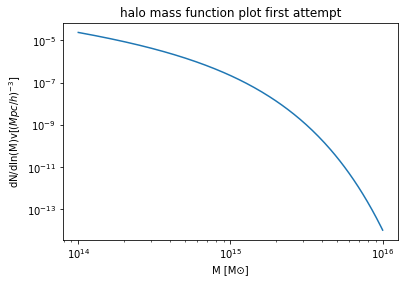

In [ ]:
plt.loglog(mass_array, mfunc)
plt.xlabel("M [M⊙]")
plt.ylabel("dN/dln(M)v[$(Mpc/ℎ)^{−3}$]")
plt.title("halo mass function plot first attempt")